Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
# !git clone https://github.com/google-research/google-research.git

In [1]:
import sys
import os
import tarfile
import urllib
import zipfile
from livelossplot import PlotLossesKeras
# sys.path.append('./google-research')

# Example of model training

Below steps are taken from [model_train_eval](https://github.com/google-research/google-research/blob/master/kws_streaming/train/model_train_eval.py) - it has more tests in streaming, non streaming, quantized and non qunatized models with TF and TFLite.

## Imports

In [2]:
# TF streaming
from models import models
from models import utils
from layers.modes import Modes

In [3]:
import tensorflow as tf
import numpy as np
# import tensorflow.compat.v1 as tf1
import logging
from models import model_flags
from models import model_params
# from train import test
# from train import train
import data
from data_generator import DataGenerator
# tf1.disable_eager_execution()

In [7]:
tf.keras.backend.clear_session()


In [ ]:
# config = tf1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf1.Session(config=config)

from tensorflow.python.client import device_lib
gous=tf.config.experimental.list_physical_devices("GPU")
print(device_lib.list_local_devices())

In [8]:
# general imports
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from timeit import default_timer as time
import os
import json
import numpy as np
import scipy as scipy
import scipy.io.wavfile as wav
import scipy.signal

In [9]:
tf.__version__

'2.3.0'

In [ ]:
# tf1.reset_default_graph()
# sess = tf1.Session()
# tf1.keras.backend.set_session(sess)
# tf1.keras.backend.set_learning_phase(0)

## Set path to data

In [10]:
# set PATH to data sets (for example to speech commands V2):
# it can be downloaded from
# https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
# if you already run "00_check-data.ipynb" then folder "data2" should be located in the current dir
current_dir = os.getcwd()
DATA_PATH = os.path.join(current_dir, "data2\\")
DATA_PATH

'f:\\datas\\kws_streaming\\data2\\'

In [ ]:
def waveread_as_pcm16(filename):
  """Read in audio data from a wav file.  Return d, sr."""
  samplerate, wave_data = wav.read(filename)
  # Read in wav file.
  return wave_data, samplerate

def wavread_as_float(filename, target_sample_rate=16000):
  """Read in audio data from a wav file.  Return d, sr."""
  wave_data, samplerate = waveread_as_pcm16(filename)
  desired_length = int(
          round(float(len(wave_data)) / samplerate * target_sample_rate))
  wave_data = scipy.signal.resample(wave_data, desired_length)

  # Normalize short ints to floats in range [-1..1).
  data = np.array(wave_data, np.float32) / 32768.0
  return data, target_sample_rate

In [ ]:
# Set path to wav file to visualize it
wav_file = os.path.join(DATA_PATH, "left\\0ff728b5_nohash_0.wav")
print(wav_file)
# read audio file
wav_data, samplerate = wavread_as_float(wav_file)

In [ ]:
assert samplerate == 16000

In [ ]:
plt.plot(wav_data)

## Set path to a model with config

In [11]:
# select model name should be one of
model_params.HOTWORD_MODEL_PARAMS.keys()

dict_keys(['svdf', 'svdf_resnet', 'ds_cnn', 'gru', 'lstm', 'cnn_stride', 'cnn', 'tc_resnet', 'crnn', 'dnn', 'att_rnn', 'att_mh_rnn', 'mobilenet', 'mobilenet_v2', 'xception', 'inception', 'inception_resnet', 'ds_tc_resnet'])

In [12]:
# This notebook is configured to work with 'ds_tc_resnet' and 'svdf'.
MODEL_NAME = 'xception'
# MODEL_NAME = 'svdf'
MODELS_PATH = os.path.join(current_dir, "model")
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME + "/")
MODEL_PATH

'f:\\datas\\kws_streaming\\model\\xception/'

In [13]:
# get toy model settings
FLAGS = model_params.HOTWORD_MODEL_PARAMS[MODEL_NAME]

In [14]:
# self_att,multi_head,att,middle_att,mh_middle_att
FLAGS.att_type='self_att'
FLAGS.dt_type='mel'

In [16]:
model_name='vn1_'+MODEL_NAME+"_"+FLAGS.dt_type+'_'+FLAGS.att_type
model_name,type(model_name)

('vn1_xception_mel_self_att', str)

In [17]:
os.makedirs('model/'+model_name,exist_ok=True)

In [18]:
# set path to data and model (where model will be stored)
FLAGS.data_dir = DATA_PATH
FLAGS.train_dir = MODEL_PATH

# set speech feature extractor properties
FLAGS.mel_upper_edge_hertz = 7600
FLAGS.window_size_ms = 25   #40
FLAGS.window_stride_ms =10 #20
FLAGS.mel_num_bins = 80
FLAGS.dct_num_features = 80
FLAGS.feature_type = 'mfcc_op'
FLAGS.preprocess = 'raw'
FLAGS.fft_magnitude_squared=1
# for numerical correctness of streaming and non streaming models set it to 1
# but for real use case streaming set it to 0
FLAGS.causal_data_frame_padding = 0

FLAGS.use_tf_fft = True
FLAGS.mel_non_zero_only = not FLAGS.use_tf_fft

# set training settings
FLAGS.train = 1
# reduced number of training steps for test only
# so model accuracy will be low,
# to improve accuracy set how_many_training_steps = '40000,40000,20000,20000'
FLAGS.how_many_training_steps = '400,400,400,400'
FLAGS.learning_rate = '0.001,0.0005,0.0001,0.00002'
FLAGS.lr_schedule = 'linear'
FLAGS.verbosity = logging.INFO

# data augmentation parameters
FLAGS.resample = 0.15
FLAGS.time_shift_ms = 100
# FLAGS.use_spec_augment = 1
# # FLAGS.time_masks_number = 2
# # FLAGS.time_mask_max_size = 10
# FLAGS.frequency_masks_number = 2
# FLAGS.frequency_mask_max_size = 5
# FLAGS.pick_deterministically = 1

In [19]:
FLAGS.model_name = MODEL_NAME

# model parameters are different for every model
if MODEL_NAME == 'xception':
  FLAGS.cnn1_kernel_size='5'
  FLAGS.cnn1_filters='16'

  FLAGS.stride1=2
  FLAGS.stride2=2
  FLAGS.stride3=1
  FLAGS.stride4=1

  FLAGS.cnn2_kernel_sizes='5,7'
  FLAGS.cnn2_filters='32,40'

  FLAGS.cnn3_kernel_sizes='7'
  FLAGS.cnn3_filters='64'

  FLAGS.cnn4_kernel_sizes ='11'
  FLAGS.cnn4_filters='100'
  
  FLAGS.units2='64'
  FLAGS.bn_scale=0
  FLAGS.dropout=0.0

else:
  raise ValueError("set parameters for other models")

In [20]:
# FLAGS.train_dir=model_name
flags = model_flags.update_flags(FLAGS)

In [ ]:
with open(os.path.join(model_name, 'flags.json'), 'wt') as f:
  json.dump(flags.__dict__, f)

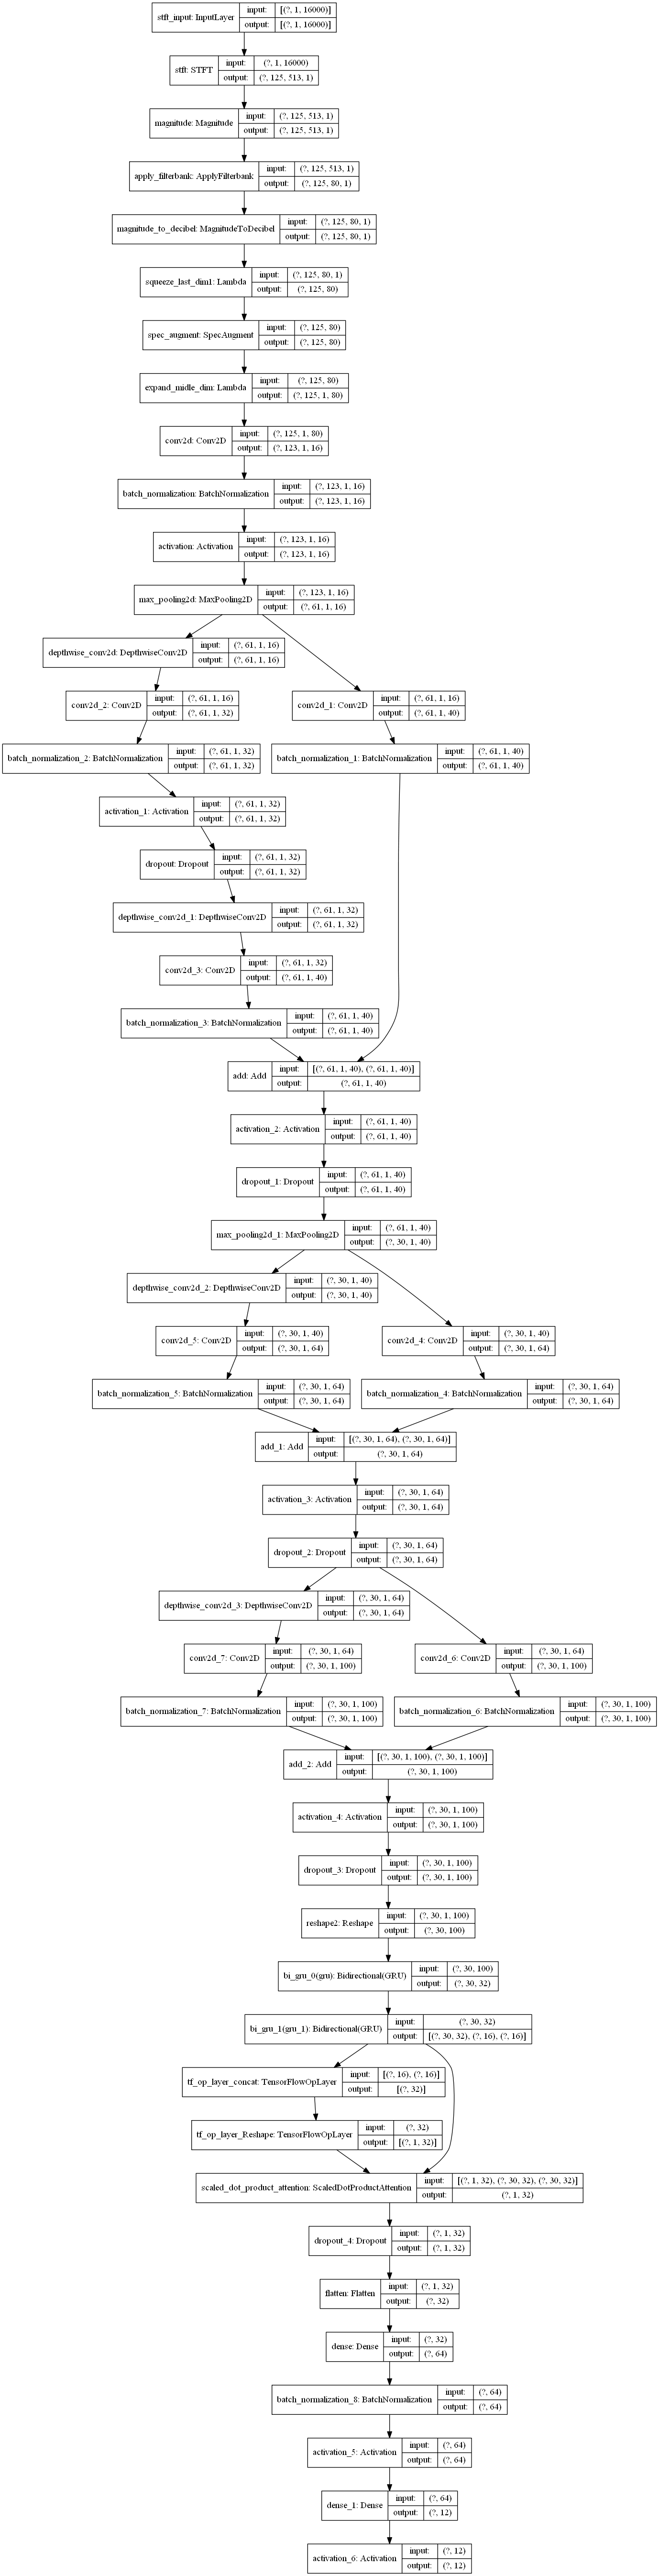

In [21]:
# visualize a model
mymodel = models.MODELS[flags.model_name](flags)
tf.keras.utils.plot_model(mymodel,show_shapes=True,show_layer_names=True, expand_nested=True,to_file='model/'+model_name+'/'+model_name+'.png')

In [ ]:
# opt=tf.keras.optimizers.Adam()
# mymodel.compile(optimizer=opt,
#             loss='categorical_crossentropy',
#             metrics=['accuracy'])
# mymodel.load_weights('model/'+model_name+'/'+model_name+'.h5')

In [22]:
mymodel.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
stft_input (InputLayer)         [(None, 1, 16000)]   0                                            
__________________________________________________________________________________________________
stft (STFT)                     (None, 125, 513, 1)  0           stft_input[0][0]                 
__________________________________________________________________________________________________
magnitude (Magnitude)           (None, 125, 513, 1)  0           stft[0][0]                       
__________________________________________________________________________________________________
apply_filterbank (ApplyFilterba (None, 125, 80, 1)   0           magnitude[0][0]                  
_______________________________________________________________________________________

In [23]:
path='model//'+model_name
file_name=model_name+'.txt'

with open(os.path.join(path, file_name), 'wt') as fd:
    stringlist = []
    mymodel.summary(print_fn=lambda x: stringlist.append(x))  # pylint: disable=unnecessary-lambda
    model_summary = '\n'.join(stringlist)
    fd.write(model_summary)

In [24]:
# 0.001,0.0005,0.0001,0.00001
training_steps_list=[20000,20000,20000,20000]
learning_rates_list=[0.001,0.0005,0.0001,0.00002 ]
training_steps_max = np.sum(training_steps_list)
lr_init = learning_rates_list[0]
exp_rate = -np.log(learning_rates_list[-1] / lr_init)/training_steps_max
exp_rate,lr_init * np.exp(-exp_rate * 100)

(4.8900287567851824e-05, 0.0009951219079689325)

In [25]:
def scheduler_expe(epoch,lr_init):
    lr=lr_init * np.exp(-exp_rate * epoch)
    # print('learning_rate',lr)
    return lr_init * np.exp(-exp_rate * epoch)

lrs = tf.keras.callbacks.LearningRateScheduler(scheduler_expe,verbose=True)

In [ ]:
borad=tf.keras.callbacks.TensorBoard(log_dir='model/'+model_name+'/')

In [ ]:
def scheduler_linear(epoch,lr):
    training_steps_sum = 0
    for i in range(len(training_steps_list)):
        training_steps_sum += training_steps_list[i]
        if epoch <training_steps_sum:
            learning_rate_value = learning_rates_list[i]
            break
    print('learning_rate',learning_rate_value)
    return learning_rate_value

lrs = tf.keras.callbacks.LearningRateScheduler(scheduler_linear)

In [26]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from glob import glob
import argparse
import warnings

In [27]:
from split_data import split

wav_train,wav_test,wav_val,label_train,label_test,label_val,classes=split(DATA_PATH)


In [28]:
classes

array(['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence',
       'stop', 'unknown', 'up', 'yes'], dtype='<U60')

In [29]:
wav_train[0]

'f:/datas/kws_streaming/data2/silence/silence.wav'

In [30]:
len(wav_train), len(wav_val),len(wav_test)

(57748, 7219, 7219)

In [31]:
def train_model(args,mymodel):
    # tf.keras.backend.clear_session()
    sr = args.sample_rate
    dt = args.delta_time
    batch_size = args.batch_size
    model_type = args.model_type
    epoch=args.epochs
    
    # assert model_type in models.keys(), '{} not an available model'.format(model_type)
    csv_path = os.path.join('model/'+model_type, '{}_history.csv'.format(model_type))

   
    tg = DataGenerator(wav_train, label_train, sr, dt,
                       n_classes=12, batch_size=batch_size,shuffle=True,dt_type='mel')
    vg = DataGenerator(wav_val, label_val, sr, dt,
                       n_classes=12, batch_size=batch_size,shuffle=True,dt_type='mel')
    
    # return tg,vg,csv_path
    model = mymodel

    cp = ModelCheckpoint('model/{}.h5'.format(model_type), monitor='val_loss',
                         save_best_only=True, save_weights_only=False,
                         mode='auto', save_freq='epoch', verbose=1)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
    plt.close()
    csv_logger = CSVLogger(csv_path, append=False)
    
    opt=tf.keras.optimizers.Adam()
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    hist=model.fit(tg, validation_data=vg,epochs=epoch, verbose=1,batch_size=batch_size,
              callbacks=[csv_logger,lrs, cp,PlotLossesKeras()])
    return model,hist



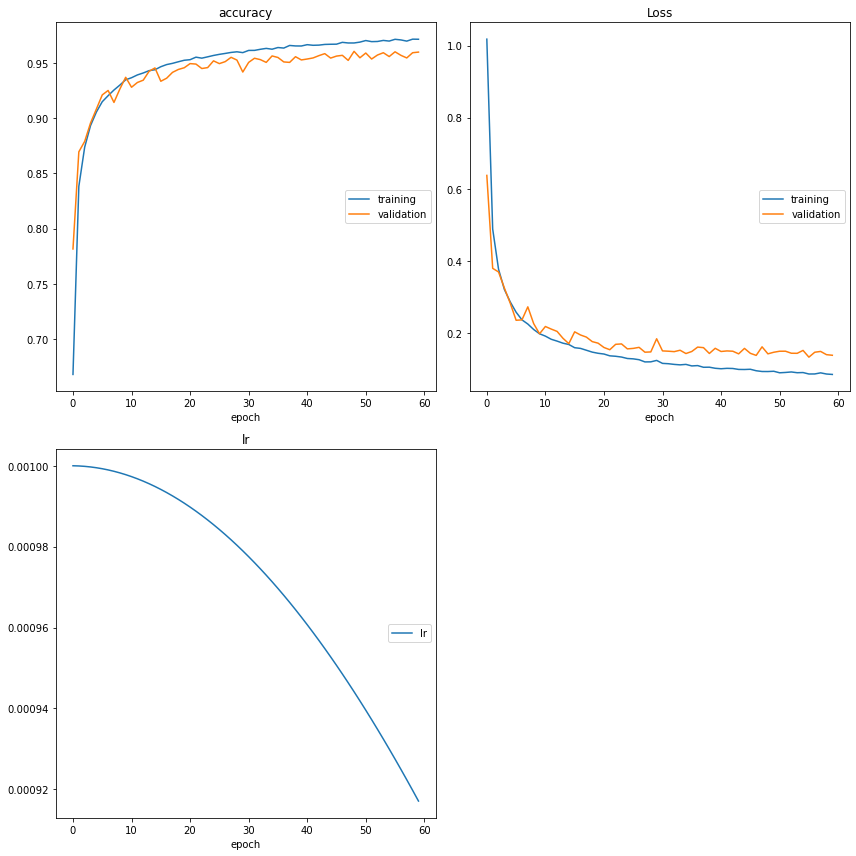

accuracy
	training         	 (min:    0.668, max:    0.971, cur:    0.971)
	validation       	 (min:    0.782, max:    0.960, cur:    0.960)
Loss
	training         	 (min:    0.085, max:    1.018, cur:    0.085)
	validation       	 (min:    0.133, max:    0.639, cur:    0.138)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
577/577 [==============================] - 274s 476ms/step - loss: 0.0847 - accuracy: 0.9714 - val_loss: 0.1380 - val_accuracy: 0.9597


In [32]:

if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='Audio Classification Training')
    parser.add_argument('--model_type', type=str, default=model_name,
                        help='model to run. i.e. conv1d, conv2d, lstm,conv1d_self_att')
    parser.add_argument('--epochs', type=str, default=60,
                        help='model to run. i.e. conv1d, conv2d, lstm,conv1d_self_att')
    parser.add_argument('--batch_size', type=int, default=100,
                        help='batch size')
    parser.add_argument('--delta_time', '-dt', type=float, default=1.0,
                        help='time in seconds to sample audio')
    parser.add_argument('--sample_rate', '-sr', type=int, default=16000,
                        help='sample rate of clean audio')
    args, _ = parser.parse_known_args()

    mymodel,his=train_model(args,mymodel)

In [33]:
log_csvs = sorted(os.listdir('model'))
print(log_csvs)

['vn10_mobilenet_mel_self_att', 'vn1_xception_mel_self_att', 'vn1_xception_mel_self_att.h5', 'vn1tc_resnet_mel_self_att', 'vn2_inception_mel_None', 'vn2_mobilenet_mel_self_att', 'vn3_mobilenet_mel_self_att', 'vn4_mobilenet_mel_self_att', 'vn5_mobilenet_mel_self_att', 'vn6_mobilenet_mel_self_att', 'vn7_mobilenet_mel_self_att', 'vn8_mobilenet_mel_self_att', 'vn9_mobilenet_mel_self_att', 'vn_inception_mel_self_att', 'vn_inception_mel_self_att.h5', 'vn_mobilenet', 'vn_mobilenet__multi_head', 'vn_mobilenet_mel_multi_head', 'vn_mobilenet_mel_self_att']


In [34]:
import pandas as pd

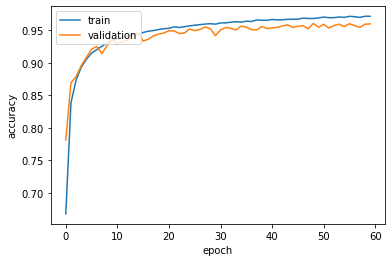

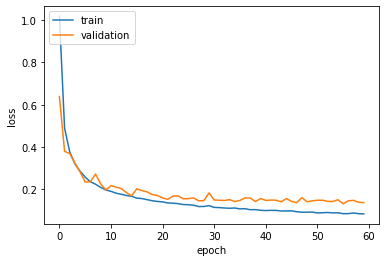

In [35]:
csv_path=os.path.join('model/'+model_name,model_name+'_history.csv')
df=pd.read_csv(csv_path)

plt.plot(df.accuracy)
plt.plot(df.val_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='upper left')
plt.savefig('model/'+model_name+'/'+'acc'+'.png')
plt.show()

plt.plot(df.loss)
plt.plot(df.val_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper left')
plt.savefig('model/'+model_name+'/'+'loss'+'.png')
plt.show()

In [36]:
def test_model(args):
    # tf.keras.backend.clear_session()
    src_root = args.src_root
    sr = args.sample_rate
    dt = args.delta_time
    batch_size = args.batch_size
    model_type = args.model_type

    test = DataGenerator(wav_test, label_test, sr, dt,
                       n_classes=12, batch_size=batch_size,shuffle=False,dt_type='mel')
    
    return test

In [37]:
if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='Audio Classification Testing')
    parser.add_argument('--model_type', type=str, default=model_name,
                        help='model to run. i.e. conv1d, conv2d, lstm')
    parser.add_argument('--src_root', type=str, default='test',
                        help='directory of audio files in total duration')
    parser.add_argument('--batch_size', type=int, default=100,
                        help='batch size')
    parser.add_argument('--delta_time', '-dt', type=float, default=1.0,
                        help='time in seconds to sample audio')
    parser.add_argument('--sample_rate', '-sr', type=int, default=16000,
                        help='sample rate of clean audio')
    args, _ = parser.parse_known_args()

    testg=test_model(args)

In [38]:
test_error, test_accuracy = mymodel.evaluate(testg)
print(f"Test error{test_error}, Test accuracy{test_accuracy}")

72/72 [==============================] - 146s 2s/step - loss: 0.1361 - accuracy: 0.9607
Test error0.1360992044210434, Test accuracy0.960694432258606


In [39]:
def eval_model(args):
    # tf.keras.backend.clear_session()
    src_root = args.src_root
    sr = args.sample_rate
    dt = args.delta_time
    batch_size = args.batch_size
    model_type = args.model_type

    tg = DataGenerator(wav_train, label_train, sr, dt,
                       n_classes=12, batch_size=batch_size,shuffle=True,dt_type='mel')
    vg = DataGenerator(wav_val, label_val, sr, dt,
                       n_classes=12, batch_size=batch_size,shuffle=True,dt_type='mel')
    return tg,vg

In [40]:
if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='Audio Classification Training')
    parser.add_argument('--model_type', type=str, default=model_name,
                        help='model to run. i.e. conv1d, conv2d, lstm,conv1d_self_att')
    parser.add_argument('--epochs', type=str, default=100,
                        help='model to run. i.e. conv1d, conv2d, lstm,conv1d_self_att')
    parser.add_argument('--src_root', type=str, default='train',
                        help='directory of audio files in total duration')
    parser.add_argument('--batch_size', type=int, default=100,
                        help='batch size')
    parser.add_argument('--delta_time', '-dt', type=float, default=1.0,
                        help='time in seconds to sample audio')
    parser.add_argument('--sample_rate', '-sr', type=int, default=16000,
                        help='sample rate of clean audio')
    args, _ = parser.parse_known_args()

    tg,vg=eval_model(args)

In [41]:
train_error, train_accuracy = mymodel.evaluate(tg)
print(f"Train error{train_error}, Train accuracy{train_accuracy}")

577/577 [==============================] - 87s 152ms/step - loss: 0.0712 - accuracy: 0.9766
Train error0.07118697464466095, Train accuracy0.9766204357147217


In [42]:
val_error, val_accuracy = mymodel.evaluate(vg)
print(f"Val error{val_error}, Val accuracy{val_accuracy}")

72/72 [==============================] - 11s 151ms/step - loss: 0.1379 - accuracy: 0.9586
Val error0.13794980943202972, Val accuracy0.9586111307144165


In [43]:
with open('model/'+model_name+'/test.txt', 'w') as f:
    f.write(f"Test error{test_error}, Test accuracy{test_accuracy}")

In [44]:
y_pred=mymodel.predict(testg)
y_true=label_test
y_pred.shape,y_true.shape

((7200, 12), (7219,))

In [45]:
y_true=y_true[:7200]
y_true.shape

(7200,)

In [46]:
from tensorflow.keras.utils import to_categorical

In [47]:
# wav_paths = glob('{}/**'.format('test'), recursive=True)
# wav_paths = sorted([x.replace(os.sep, '/') for x in wav_paths if '.wav' in x])
# classes = sorted(os.listdir('test'))
# labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
# le = LabelEncoder()
# y_true = le.fit_transform(labels)
y_hot = to_categorical(y_true)
y_pred_le = np.argmax(y_pred, axis=1)
y_pred_labels = [classes[x] for x in y_pred_le]
y_true_labels = [classes[x] for x in y_true]

In [48]:
y_pred_labels[0:10],y_true_labels[0:10],label_test[0:10],classes

(['unknown',
  'stop',
  'unknown',
  'silence',
  'on',
  'down',
  'yes',
  'silence',
  'left',
  'stop'],
 ['unknown',
  'stop',
  'unknown',
  'silence',
  'on',
  'down',
  'yes',
  'silence',
  'left',
  'stop'],
 array([ 9,  8,  9,  7,  5,  0, 11,  7,  2,  8]),
 array(['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence',
        'stop', 'unknown', 'up', 'yes'], dtype='<U60'))

In [49]:
print(y_pred.shape)

(7200, 12)


In [50]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, plot_confusion_matrix
import pylab
import seaborn as sns
import pandas as pd

In [51]:
n_classes = len(set(y_true))
fpr = dict()
tpr = dict()
fnr=dict()
roc_auc = dict()
roc_auc2=dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_hot[:, i], y_pred[:, i])
    fnr[i]=1-tpr[i]
    roc_auc[i] = auc(fpr[i], tpr[i])
    roc_auc2[i]=auc(fpr[i],fnr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_hot.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

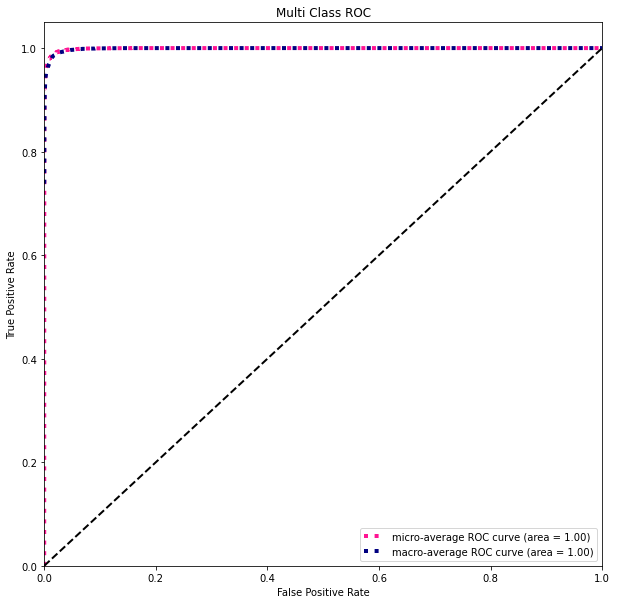

In [53]:
#  First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi Class ROC')
legend = plt.legend()
legend._legend_box.align = "right"
plt.legend(loc="lower right")
plt.savefig('model/'+model_name+'/'+'macro-micro.png')


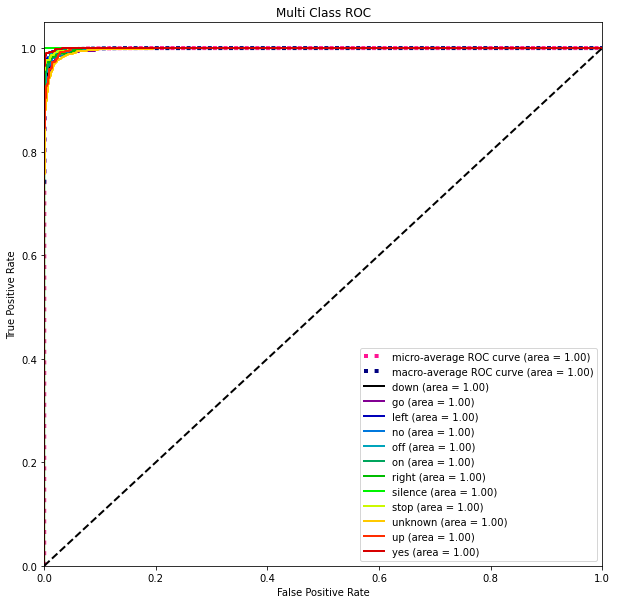

In [52]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = []
cm = pylab.get_cmap('nipy_spectral')
for i in range(n_classes):
    color = cm(1.*i/n_classes)
    colors.append(color)
unique_labels = np.unique(classes)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (area = {1:0.2f})'.format(unique_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi Class ROC')
legend = plt.legend()
legend._legend_box.align = "right"
plt.legend(loc="lower right")
plt.savefig('model/'+model_name+'/'+'roc.png')
plt.show()

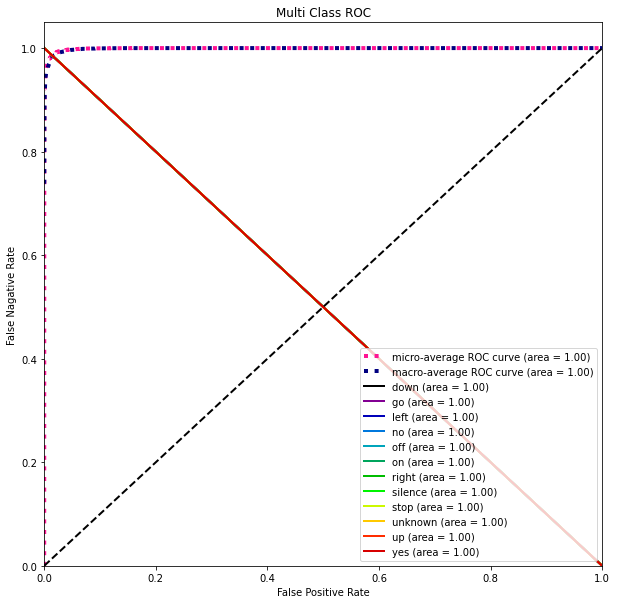

In [54]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = []
cm = pylab.get_cmap('nipy_spectral')
for i in range(n_classes):
    color = cm(1.*i/n_classes)
    colors.append(color)
unique_labels = np.unique(classes)

for i, color in zip(range(n_classes), colors):
    plt.plot(fnr[i], tpr[i], color=color, lw=2,
             label='{0} (area = {1:0.2f})'.format(unique_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('False Nagative Rate')
plt.title('Multi Class ROC')
legend = plt.legend()
legend._legend_box.align = "right"
plt.legend(loc="lower right")
plt.savefig('model/'+model_name+'/'+'nroc.png')
plt.show()

In [55]:
len(y_true_labels),len(y_pred_labels)

(7200, 7200)

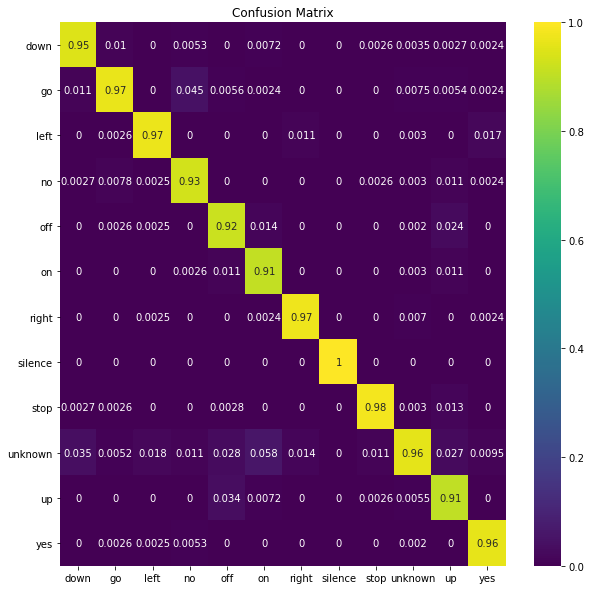

In [56]:
conf_mat = confusion_matrix(y_true_labels, y_pred_labels, labels=unique_labels,normalize='pred')
df_cm = pd.DataFrame(conf_mat, index = unique_labels,
                     columns = unique_labels)
plt.figure(figsize = (10,10))
plt.title('Confusion Matrix')
sns.heatmap(df_cm, annot=True, cmap='viridis')
plt.savefig('model/'+model_name+'/'+'confmatrix.png')
plt.show()

In [57]:
from sklearn.metrics import classification_report
dt=classification_report(y_hot.argmax(axis=1), y_pred.argmax(axis=1), target_names=unique_labels)
with open('model/'+model_name+'/classification_report.txt', 'w') as f:
    f.write(dt)

In [59]:
model_name

'vn1_xception_mel_self_att'

In [60]:
import shutil
src='models/xception.py'
dst='model/'+model_name+'/'+'xception.py'
shutil.copyfile(src,dst)

'model/vn1_xception_mel_self_att/xception.py'

In [ ]:
import tensorflow as tf
import datetime, os

logs_base_dir = 'model/'+"mobilenet"+'/'
# os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}